# Estimate model of WTI oil futures

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()



Download dataset with latest data
(Data is for every business day)

In [2]:
raw_data = pd.read_excel("https://www.eia.gov/dnav/pet/hist_xls/RCLC1d.xls", sheet_name=1, header=2)

In [3]:
raw_data.head()

,Date,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)"
0,1983-04-04,29.44
1,1983-04-05,29.71
2,1983-04-06,29.92
3,1983-04-07,30.17
4,1983-04-08,30.38


In [4]:
# check date of the oldest and the newest entry
print("Oldest entry: ", raw_data["Date"].min())
print("Newest entry: ", raw_data["Date"].max())

Oldest entry:  1983-04-04 00:00:00
Newest entry:  2020-03-19 00:00:00


In [5]:
# set date as index for easier time series handling
time_indexed_data = raw_data.set_index("Date")
time_indexed_data.head()

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)"
Date,
1983-04-04,29.44
1983-04-05,29.71
1983-04-06,29.92
1983-04-07,30.17
1983-04-08,30.38


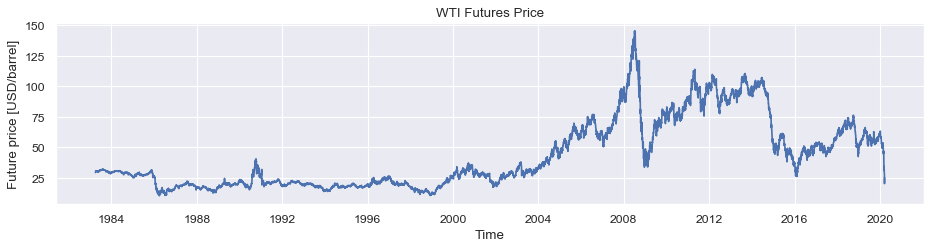

In [6]:
plt.figure(figsize=(14, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(time_indexed_data)
plt.title("WTI Futures Price")
plt.xlabel("Time")
plt.ylabel("Future price [USD/barrel]")
plt.show()

Select time interval

In [7]:
selected_ti = time_indexed_data.loc["2000-01-01":]
selected_ti.count()

Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)    5079
dtype: int64

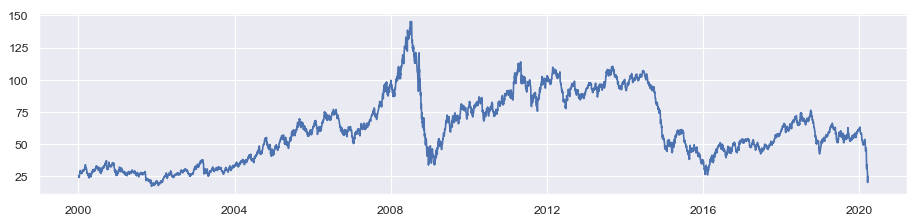

In [8]:
plt.figure(figsize=(14, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(selected_ti)
plt.show()

In [9]:
rets = (selected_ti/selected_ti.shift(1))
rets = rets[rets.columns[0]].dropna()
#rets = selected_ti.pct_change()
#rets = rets.rename(columns={rets.columns[0] : "% return"})
#rets["% return"] = rets["% return"].dropna()

In [10]:
lrets = np.log(rets)

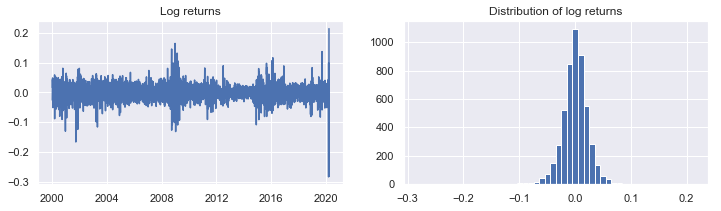

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,3))
ax1.set_title("Log returns")
ax1.plot(lrets)
ax2.set_title("Distribution of log returns")
ax2.hist(lrets,bins=50)
plt.show()

Estimate parameters for GBM
(In this case mean and std of the log returns, based on [this](https://quant.stackexchange.com/questions/35194/estimating-the-historical-drift-and-volatility)).

In [12]:
# these values are calculated from all data since 2000
sample_mean_returns = np.mean(lrets)
sample_std_returns = np.std(lrets)
print(sample_mean_returns, sample_std_returns)

-2.5600602821844478e-06 0.024628050209519827


Strike prices for average option can be seen on [CME website](https://www.cmegroup.com/trading/energy/crude-oil/west-texas-intermediate-wti-crude-oil-calendar-swap-futures_quotes_settlements_options.html?optionProductId=2767&optionExpiration=2767-H0#optionProductId=2767&optionExpiration=2767-H0&tradeDate=03%2F23%2F2020). Strikes are there in cents.

In [13]:
strike = 20 # in USD per barrel, arbitrarily chosen
discount_rate = 0.1 # chosen discount rate
time_to_maturity = 1.0/12.0 # value of 1 means one year so 1/12th is one month
current_price = selected_ti.iloc[-1,0] # latest future price
steps = 20 # calculate business days in a month, this is only a guess for now
simulations = 500
# following two values are calculated from daily values, so I adjusted the code for the simulation model
# dt is in 1 if I input daily values
drift_strength = sample_mean_returns
volatility = sample_std_returns
position_flag = "c" # simulate for call option

In [14]:
from simulations.gbm import asian_gbm_fixed
price, paths, step_range = asian_gbm_fixed(
    current_price, 
    strike,
    position_flag=position_flag,
    time_to_maturity=time_to_maturity,
    steps=steps,
    simulations=simulations,
    drift_strength=drift_strength,
    v=volatility,
    r=discount_rate
    )

This model is supposed to price an average option on WTI future, which expires 20 business days from last available business day. The assumption I do here is that 20 business days from now is the last day of a month, on which the option expires (NYMEX contract condition)

Price:  5.238668302884737


<Figure size 1120x240 with 0 Axes>

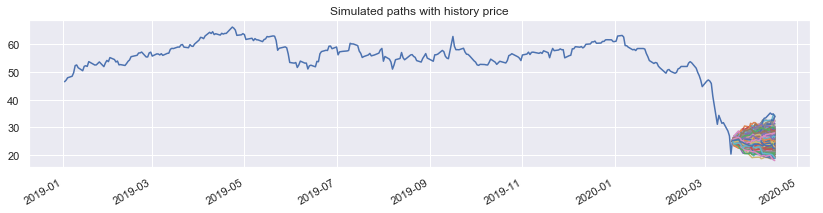

In [15]:
import matplotlib.dates as mdates
print("Price: ", price)
plt.figure(figsize=(14, 3), dpi= 80, facecolor='w', edgecolor='k')
previous_part = selected_ti.loc["2019-01-01":]
sim_dates = pd.bdate_range(start=selected_ti.index[-1],periods=len(step_range))
start_d = previous_part.index[0]
end_d = sim_dates[-1]


fig, ax = plt.subplots(1, 1, figsize=(14,3))
ax.set_title("Simulated paths with history price")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.plot(previous_part)
for path in paths:
    ax.plot(sim_dates, path)
fig.autofmt_xdate()
plt.show()

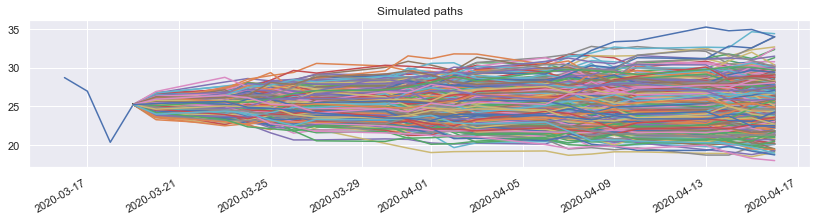

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(14,3))
ax.set_title("Simulated paths")
ax.plot(selected_ti.loc["2020-03-15":])
for path in paths:
    ax.plot(sim_dates, path)
fig.autofmt_xdate()
plt.show()

The model used above is a simplification, since the returns are not normally distributed, as can be seen below. Distribution is almost symmetrical, its kurtosis is however much bigger than that of normal distribution. The data are therefore leptokurtic and have fatter tails.


Jarque Bera test (tests for normality of data)
          Score  p value      skew   kurtosis
0  17954.285004      0.0 -0.123246  12.208477

Ljung-Box test ( tests autocorrelation)
      lb_stat  lb_pvalue
30  50.856372   0.010087


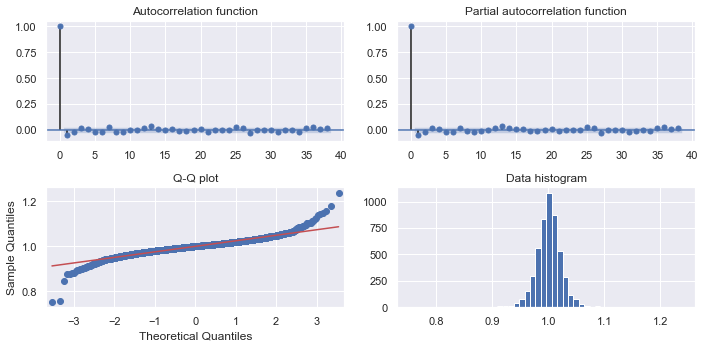

In [17]:
from helper_functions.evaluate_timeseries import evaluate_ts_data
evaluate_ts_data(rets)

Based on the tests above we can see that while there is very little autocorrelation, the returns are not normally distributed and therefore the GBM is not an accurate representation of WTI futures prices. The model would be sufficient in times when the oil and its futures do not have sudden extreme price changes.